# Macro Directional (ETF)

Asset Classes: Commodities, REITs, Bonds, Equity Indices, and Bitcoin

## Import Libraries

In [1]:
import pandas as pd
pd.options.display.float_format = "{:,.3f}".format
from pandas.tseries.offsets import BDay
import pandas_datareader as wb

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import numpy as np
import datetime as dt

## Retrieve Data

In [2]:
# define tickers
equities = 'SPY QQQ XLY XLV XLP EEM VIG ARKK ESGU'.split()
bonds = 'AGG BND BNDX EMB HYG IEF IEI IGSB LQD SHY TIP TLT'.split()
reits = 'VNQ'.split()
commods = 'GLD SLV XLE'.split()
crypto = 'BITO'.split()
tickers = equities + bonds + reits + commods + crypto

In [3]:
%%time
data = wb.DataReader(name=tickers, data_source='yahoo', start='2003-01-01', end=dt.date.today())['Adj Close']

Wall time: 1min 41s


## Visualize Time-Series

### Bond ETFs

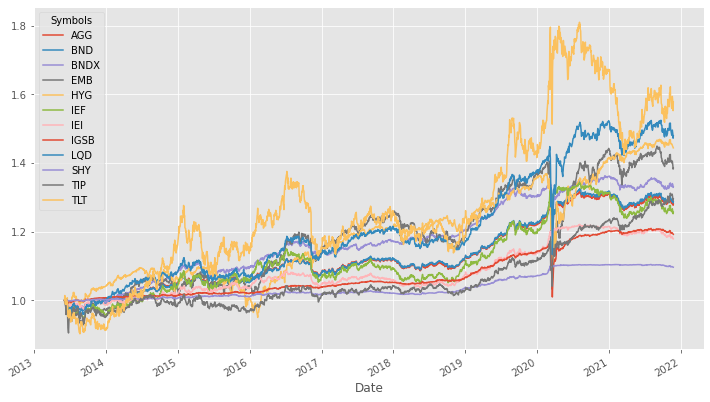

In [4]:
bonds_data = data[[col for col in data.columns if col in bonds]].copy().dropna()
(bonds_data / bonds_data.iloc[0]).plot(figsize=(12,7))
plt.show()

### Non-Bond ETFs

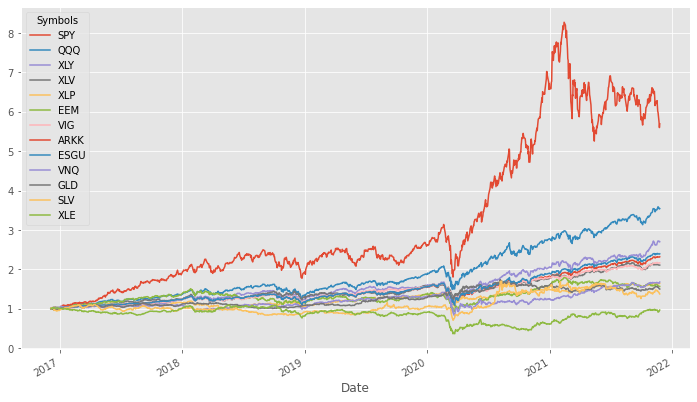

In [5]:
other_data = data[[col for col in data.columns if (col in commods) or (col in reits) or (col in equities)]].copy().dropna()
(other_data / other_data.iloc[0]).plot(figsize=(12,7))
plt.show()

## Set Parameters and Dates

In [6]:
# strategy parameters
lookback = 12
threshold = 0.90
max_assets = 15
min_assets = 10

# resample dates to monthly timeframe
critical = data.resample('BMS').mean().index
while [date for date in critical if date not in data.index] != []:
    critical = [date if date in data.index else date+BDay(1) for date in critical]

# capture important dates
start = critical[:-lookback]
rebalance_dates = critical[lookback:]
end = [date-BDay(1) for date in rebalance_dates]

# check sample of lookback and allocation period
i = 12
print(f"Lookback starts : {start[i].date()}")
print(f"Lookback ends   : {end[i].date()}")
print(f"Rebalance on    : {rebalance_dates[i].date()}")

Lookback starts : 2003-12-01
Lookback ends   : 2004-11-30
Rebalance on    : 2004-12-01


## Create Allocation DataFrame

In [7]:
# prepare allocation dataframe
allocation = data.copy()
allocation.loc[:] = np.nan

# loop over rebalancing period
for i in range(len(rebalance_dates)):
    
    # define dates for ease of reference
    start_look = start[i]
    end_look = end[i]
    start_rebal = rebalance_dates[i]
    try: end_rebal = rebalance_dates[i+1] - BDay(1) # monthly rebalancing
    except: end_rebal = None
    
    # slice lookback window and drop incomplete dataset
    df = data.loc[start_look:end_look].dropna(axis=1, how='any')
    
    # exclude SPY
    df.drop('SPY', axis=1, inplace=True)
    
    # capture maximum price during lookback window
    max_price = df.max()
    
    # capture the first price data at the beginning of rebalancing period
    first_price = data.loc[start_rebal, df.columns]
    ratio = first_price / max_price
    
    # select long candidates
    long_names = first_price[first_price > (threshold * max_price)].index.tolist()
    long_names = ratio[long_names].nlargest(max_assets).index.tolist()
    
    # define conditions for long trades
    if len(long_names) >= min_assets:
        
        print(f"Lookback starts : {start_look.date()}")
        print(f"Lookback ends   : {end_look.date()}")
        print(f"Hold from       : {start_rebal.date()}")
        if end_rebal is not None:
            print(f"Hold until      : {end_rebal.date()}")
        else: pass
        print(f"Long names ({len(long_names)}) : {', '.join(long_names)}")
        print('==========================================')
        
        # allocate capital equally
        try:
            allocation.loc[start_rebal:end_rebal, long_names] = 1 / len(long_names)
        except:
            allocation.loc[start_rebal:, long_names] = 1 / len(long_names)

Lookback starts : 2003-10-01
Lookback ends   : 2004-09-30
Hold from       : 2004-10-01
Hold until      : 2004-10-29
Long names (11) : XLE, SHY, AGG, IEF, LQD, TLT, XLY, EEM, XLP, QQQ, XLV
Lookback starts : 2003-11-03
Lookback ends   : 2004-10-29
Hold from       : 2004-11-01
Hold until      : 2004-11-30
Long names (10) : XLY, SHY, AGG, LQD, IEF, TLT, EEM, QQQ, XLE, XLP
Lookback starts : 2003-12-01
Lookback ends   : 2004-11-30
Hold from       : 2004-12-01
Hold until      : 2004-12-31
Long names (11) : QQQ, EEM, XLY, SHY, AGG, LQD, IEF, XLE, TLT, XLP, XLV
Lookback starts : 2004-01-02
Lookback ends   : 2004-12-31
Hold from       : 2005-01-03
Hold until      : 2005-01-31
Long names (12) : LQD, SHY, AGG, TIP, XLP, IEF, XLY, EEM, TLT, QQQ, XLV, XLE
Lookback starts : 2004-02-02
Lookback ends   : 2005-01-31
Hold from       : 2005-02-01
Hold until      : 2005-02-28
Long names (12) : XLE, EEM, LQD, AGG, TLT, XLP, SHY, IEF, TIP, XLY, XLV, QQQ
Lookback starts : 2004-03-01
Lookback ends   : 2005-02-

Lookback starts : 2007-09-04
Lookback ends   : 2008-09-01
Hold from       : 2008-09-02
Hold until      : 2008-09-30
Long names (11) : IGSB, BND, SHY, AGG, TLT, IEF, TIP, IEI, XLP, LQD, HYG
Lookback starts : 2008-01-02
Lookback ends   : 2009-01-01
Hold from       : 2009-01-02
Hold until      : 2009-01-30
Long names (10) : BND, SHY, AGG, IGSB, IEI, LQD, IEF, EMB, TLT, TIP
Lookback starts : 2008-06-02
Lookback ends   : 2009-05-29
Hold from       : 2009-06-01
Hold until      : 2009-06-30
Long names (11) : IGSB, SHY, EMB, BND, GLD, LQD, AGG, TIP, IEI, IEF, HYG
Lookback starts : 2008-07-01
Lookback ends   : 2009-06-30
Hold from       : 2009-07-01
Hold until      : 2009-07-31
Long names (11) : BND, SHY, LQD, IGSB, EMB, AGG, TIP, IEI, GLD, HYG, IEF
Lookback starts : 2008-08-01
Lookback ends   : 2009-07-31
Hold from       : 2009-08-03
Hold until      : 2009-08-31
Long names (11) : EMB, HYG, IGSB, AGG, BND, SHY, LQD, TIP, GLD, IEI, IEF
Lookback starts : 2008-09-02
Lookback ends   : 2009-08-31
Ho

Lookback starts : 2011-08-01
Lookback ends   : 2012-07-31
Hold from       : 2012-08-01
Hold until      : 2012-09-03
Long names (15) : EMB, HYG, TIP, IGSB, SHY, LQD, AGG, IEI, BND, IEF, XLP, XLV, VNQ, VIG, TLT
Lookback starts : 2011-09-01
Lookback ends   : 2012-09-03
Hold from       : 2012-09-04
Hold until      : 2012-09-28
Long names (15) : XLV, EMB, HYG, SHY, BND, IGSB, AGG, IEI, LQD, TIP, VNQ, QQQ, XLP, IEF, VIG
Lookback starts : 2011-10-03
Lookback ends   : 2012-09-28
Hold from       : 2012-10-01
Hold until      : 2012-10-31
Long names (15) : LQD, XLV, EMB, BND, TIP, SHY, IEI, AGG, XLP, IGSB, IEF, VIG, GLD, XLY, HYG
Lookback starts : 2011-11-01
Lookback ends   : 2012-10-31
Hold from       : 2012-11-01
Hold until      : 2012-11-30
Long names (15) : SHY, IGSB, AGG, BND, TIP, IEI, LQD, HYG, EMB, IEF, VIG, XLY, XLV, XLP, GLD
Lookback starts : 2011-12-01
Lookback ends   : 2012-11-30
Hold from       : 2012-12-03
Hold until      : 2013-01-01
Long names (15) : TIP, HYG, IEI, SHY, BND, AGG, 

Lookback starts : 2014-05-01
Lookback ends   : 2015-04-30
Hold from       : 2015-05-01
Hold until      : 2015-05-29
Long names (15) : IGSB, SHY, HYG, EMB, IEI, AGG, QQQ, BNDX, BND, TIP, XLY, VIG, XLP, IEF, XLV
Lookback starts : 2014-06-02
Lookback ends   : 2015-05-29
Hold from       : 2015-06-01
Hold until      : 2015-06-30
Long names (15) : XLV, HYG, SHY, IGSB, QQQ, IEI, XLY, AGG, EMB, VIG, BND, BNDX, XLP, TIP, IEF
Lookback starts : 2014-07-01
Lookback ends   : 2015-06-30
Hold from       : 2015-07-01
Hold until      : 2015-07-31
Long names (15) : SHY, IGSB, XLY, IEI, XLV, HYG, AGG, QQQ, EMB, XLP, BND, BNDX, TIP, VIG, IEF
Lookback starts : 2014-08-01
Lookback ends   : 2015-07-31
Hold from       : 2015-08-03
Hold until      : 2015-08-31
Long names (15) : XLP, SHY, IGSB, XLY, IEI, XLV, AGG, BND, BNDX, QQQ, IEF, VIG, TIP, HYG, EMB
Lookback starts : 2014-09-02
Lookback ends   : 2015-08-31
Hold from       : 2015-09-01
Hold until      : 2015-09-30
Long names (13) : SHY, IGSB, IEI, AGG, BND, 

Lookback starts : 2018-02-01
Lookback ends   : 2019-01-31
Hold from       : 2019-02-01
Hold until      : 2019-02-28
Long names (15) : BNDX, HYG, IGSB, SHY, EMB, AGG, LQD, BND, IEI, VNQ, TIP, IEF, TLT, GLD, XLV
Lookback starts : 2018-03-01
Lookback ends   : 2019-02-28
Hold from       : 2019-03-01
Hold until      : 2019-03-29
Long names (15) : HYG, IGSB, SHY, BNDX, EMB, AGG, LQD, BND, IEI, TIP, IEF, VNQ, VIG, XLV, ARKK
Lookback starts : 2018-04-02
Lookback ends   : 2019-03-29
Hold from       : 2019-04-01
Hold until      : 2019-04-30
Long names (15) : EMB, HYG, VNQ, SHY, VIG, IGSB, XLP, BNDX, TIP, LQD, AGG, BND, IEI, IEF, XLY
Lookback starts : 2018-05-01
Lookback ends   : 2019-04-30
Hold from       : 2019-05-01
Hold until      : 2019-05-31
Long names (15) : BNDX, SHY, BND, IGSB, AGG, EMB, IEI, TIP, HYG, LQD, IEF, ESGU, QQQ, VIG, XLP
Lookback starts : 2018-06-01
Lookback ends   : 2019-05-31
Hold from       : 2019-06-03
Hold until      : 2019-06-28
Long names (15) : TLT, IEF, IEI, LQD, BND,

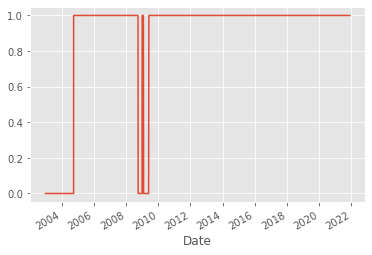

In [8]:
allocation.sum(axis=1).plot(); plt.show() # long-only

## Backtest Strategy

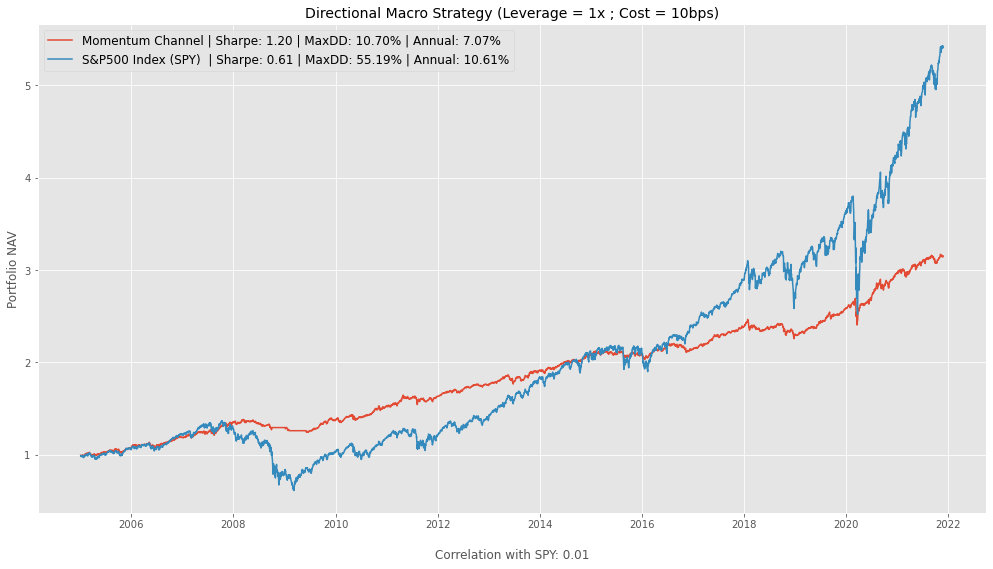

In [9]:
# set trading cost (in bps)
tc = 10
leverage = 1
start_test = '2005'
end_test = None

# calculate daily portfolio return
strat = (data.pct_change() * allocation.shift(2) * leverage).sum(axis=1).loc[start_test:end_test]
bench = data.loc[start_test:end_test,'SPY'].pct_change()

# deduct transaction cost
cost = tc / 10000
turnover = (allocation * leverage).diff().shift().fillna(0).abs()
strat = strat - (turnover * cost).sum(axis=1)

# functionalize Sharpe ratio
def sharpe(daily_return):
    return daily_return.mean() / daily_return.std() * np.sqrt(250)

# functionalize maximum drawdown
def max_dd(daily_return):
    roll_max = (daily_return + 1).cumprod().expanding().max()
    daily_dd = (daily_return + 1).cumprod() / roll_max.values - 1.0
    max_dd = daily_dd.abs().max() * 100
    return max_dd

# functionalize annualized return
def annualized_return(daily_return):
    cum_return = (daily_return + 1).cumprod().dropna()
    ann_return = (cum_return.iloc[-1] / cum_return.iloc[0]) ** (1 / len(cum_return) * 252) - 1
    ann_return = ann_return * 100
    return ann_return

# plot PnL
plt.figure(figsize=(17,9))
plt.plot((strat + 1).cumprod(), label=f"Momentum Channel | Sharpe: {sharpe(strat):.2f} | MaxDD: {max_dd(strat):.2f}% | Annual: {annualized_return(strat):.2f}%")
plt.plot((bench + 1).cumprod(), label=f"S&P500 Index (SPY)  | Sharpe: {sharpe(bench):.2f} | MaxDD: {max_dd(bench):.2f}% | Annual: {annualized_return(bench):.2f}%")
plt.title(f'Directional Macro Strategy (Leverage = {leverage}x ; Cost = {tc}bps)', fontsize=14)
plt.xlabel(f"\nCorrelation with SPY: {strat.corr(data['SPY']):.2f}", fontsize=12)
plt.ylabel('Portfolio NAV', fontsize=12)
plt.legend(fontsize=12)
plt.show()

# save return to csv file
#strat.to_csv('macro_momentum_return.csv')

## Latest Allocation

In [11]:
allocation.iloc[-1].dropna()

Symbols
QQQ    0.067
XLY    0.067
XLV    0.067
XLP    0.067
VIG    0.067
ESGU   0.067
AGG    0.067
BND    0.067
HYG    0.067
IGSB   0.067
LQD    0.067
SHY    0.067
TIP    0.067
VNQ    0.067
XLE    0.067
Name: 2021-11-24 00:00:00, dtype: float64

# The End